# Roads and Cables

In [ ]:
%%capture
try:
    import w2l
except:
    !pip install --upgrade git+https://gitlab.windenergy.dtu.dk/TOPFARM/wind2loads.git    
try:
    import workshop
except:
    try:
      !git clone https://gitlab.windenergy.dtu.dk/TOPFARM/workshop-december-2019.git
    except:
        pass
    !pip install -e ./workshop-december-2019
    import sys
    sys.path.append('./workshop-december-2019')
try:
    import topfarm
except:
    !pip install topfarm
import workshop
import os
workshop.w2l_path = 'workshop-december-2019/workshop/wind2loads_ann'

In [ ]:
!pip install pbr

In [ ]:
!pip install --upgrade git+https://gitlab.windenergy.dtu.dk/TOPFARM/wind2loads.git    

In colab, use the "inline" backend

In [ ]:
# non-updating, inline plots
%matplotlib inline
# ...or updating plots in new window
#%matplotlib qt

Let's import a few classes

In [ ]:
# import workshop
# workshop.cabling

In [ ]:
import numpy as np
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm import TopFarmGroup, TopFarmProblem
from topfarm.easy_drivers import EasyRandomSearchDriver, EasyScipyOptimizeDriver
from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.cost_models.electrical.simple_msp import ElNetLength, ElNetCost 
import matplotlib.pylab as plt

# Convenient plot component for plotting the cables from simple_msp in jupyter notebooks
from workshop.cabling import XYCablePlotComp

### Setting up the site to optimize
We will use the IEA-37 site, using the DTU 10MW reference turbine

In [ ]:
from workshop.cabling import get_site
from py_wake.examples.data.dtu10mw import DTU10MW



site = get_site()
n_wt = len(site.initial_position)
windTurbines = DTU10MW()
Drotor_vector = [windTurbines.diameter()] * n_wt 
power_rated_vector = [float(windTurbines.power(20)/1000)] * n_wt 
hub_height_vector = [windTurbines.hub_height()] * n_wt 
rated_rpm_array = 12. * np.ones([n_wt])

print('Number of turbines:', n_wt)

### Setting up the AEP calculator
- Using the Gaussian wake model from Bastankhah & Porté Agel
- Based on 16 wind direction to speed things up (not critical here because we will be using the RandomSearch algorithm)

In [ ]:
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.aep_calculator import AEPCalculator

## We use the Gaussian wake model
windFarmModel = IEA37SimpleBastankhahGaussian(site, windTurbines)

## The AEP is calculated using n_wd wind directions
n_wd = 16
wind_directions = np.linspace(0., 360., n_wd, endpoint=False)

def aep_func(x, y, **kwargs):
    """A simple function that takes as input the x,y position of the turbines and return the AEP"""
    return windFarmModel(x, y, wd=wind_directions).aep().sum(['wd','ws'])*10**6

### Setting up the NREL IRR cost model
Based on the 2006 NREL report

In [ ]:
from topfarm.cost_models.economic_models.turbine_cost import economic_evaluation as EE_NREL

def irr_nrel(aep, electrical_connection_cost, **kwargs):
    return EE_NREL(Drotor_vector, power_rated_vector, hub_height_vector, aep, electrical_connection_cost).calculate_irr()


### Setting up the DTU IRR cost model
Based on Witold's recent work

In [ ]:
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation as EE_DTU

distance_from_shore = 10.0 # [km]
energy_price = 0.2 / 7.4 # [DKK/kWh] / [DKK/EUR] -> [EUR/kWh]
project_duration = 20 # [years]
water_depth_array = 20 * np.ones([n_wt])
Power_rated_array = np.array(power_rated_vector)/1.0E3 # [MW]

ee_dtu = EE_DTU(distance_from_shore, energy_price, project_duration)


def irr_dtu(aep, electrical_connection_cost, **kwargs):
    ee_dtu.calculate_irr(
                    rated_rpm_array, 
                    Drotor_vector, 
                    Power_rated_array,
                    hub_height_vector, 
                    water_depth_array, 
                    aep, 
                    electrical_connection_cost)
    return ee_dtu.IRR

### Setting up the Topfarm problem

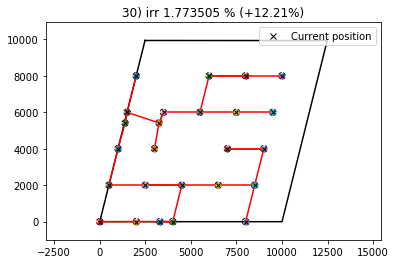

In [ ]:
## Some user options
#@markdown Which IRR Cost model to use
IRR_COST = 'DTU' #@param ["DTU", "NREL"]

#@markdown Minimum spacing between the turbines
min_spacing = 2 #@param {type:"slider", min:2, max:10, step:1}

#@markdown Minimum spacing between the turbines
cable_cost_per_meter = 750. #@param {type:"slider", min:0, max:10000, step:1}

## Electrical grid cable components (Minimum spanning tree from Topfarm report 2010)
elnetlength = ElNetLength(n_wt=n_wt)
elnetcost = ElNetCost(n_wt=n_wt, output_key='electrical_connection_cost', cost_per_meter=cable_cost_per_meter)

# The Topfarm IRR cost model components
irr_dtu_comp = CostModelComponent(input_keys=['aep', ('electrical_connection_cost', 0.0)],   n_wt=n_wt, 
                                  cost_function=irr_dtu, output_key="irr", output_unit="%",   objective=True, income_model=True)
irr_nrel_comp = CostModelComponent(input_keys=['aep', ('electrical_connection_cost', 0.0)],   n_wt=n_wt, 
                                   cost_function=irr_nrel, output_key="irr", output_unit="%",   objective=True, income_model=True)
irr_cost_models = {'DTU': irr_dtu_comp, 'NREL': irr_nrel_comp}


## The Topfarm AEP component
aep_comp = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func, 
                              output_key="aep", output_unit="GWh", objective=False, output_val=np.zeros(n_wt))

## Plotting component
plot_comp = XYCablePlotComp(memory=0, plot_improvements_only=False, plot_initial=False)


## The group containing all the components
group = TopFarmGroup([aep_comp, elnetlength, elnetcost, irr_cost_models[IRR_COST]])

problem = TopFarmProblem(
        design_vars=dict(zip('xy', site.initial_position.T)),
        cost_comp=group,
        driver=EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition_Circle(), max_iter=10),
        constraints=[SpacingConstraint(min_spacing * windTurbines.diameter(0)),
                     XYBoundaryConstraint(site.boundary)],
        expected_cost=1.0,
        plot_comp=plot_comp)

cost, state, recorder = problem.optimize()

### Exercises
- Try to see what is the effect of increasing or decreasing the cost of the cable
- Change between IRR cost model. Ask Witold about the difference between DTU and NREL models